In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
import seaborn as sns
from joblib import dump

RANDOM_STATE = 42

In [2]:
df = pd.read_csv("../data/audio/processed/audio_features.csv")

# cool visual for presenttion
# y, sr = librosa.load("../data/audio/raw/Lisa_01.wav", sr=22050)
# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
# S_db = librosa.power_to_db(S, ref=np.max)
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram')
# plt.tight_layout()
# plt.show()

In [3]:
# slplit data into tain/testing + encode speaker names
x = df.drop(columns=["speaker", "session"], axis=1)
y = df["speaker"]
y_encoded = df["speaker"].map({"Drake":0, "Melissa":1, "Lisa":2, "Dan":3, "David":4})
groups = df["session"]

# auto target encoding?
# label_encoder = LabelEncoder()
# y_encoded2 = label_encoder.fit_transform(y)
# print("Classes:", label_encoder.classes_)

# feature correlations:
# mi = mutual_info_classif(x, y_encoded)

# # Create a DataFrame to view the results
# mi_df = pd.DataFrame({"Feature": x.columns, "Mutual Information": mi})
# mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)
# print(mi_df)

Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25355_f92752225ec54dfb96c5f649781317c8_ae707991663c4505b733f3879db011cb for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25355-r04f3yoo for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", lin

SVC:
Best F1: 0.7687543991024927
Best Params: {'classifier__C': 25, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'selector__k': 'all'}


Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25355_ed912dc7464945f39d55c66629335547_83c140f252fc47fdb1ed92cc99c3e31d for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/miniconda3/envs/machine_learning/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25355_f92752225ec54dfb96c5f649781317c8_11580da341e34e5e83e6dfb13ce38344 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/home/davb001/minic

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1436
           1       0.98      0.96      0.97       958
           2       0.97      0.97      0.97      1257
           3       0.98      0.99      0.98      1916
           4       0.97      0.98      0.98      1375

    accuracy                           0.98      6942
   macro avg       0.98      0.98      0.98      6942
weighted avg       0.98      0.98      0.98      6942



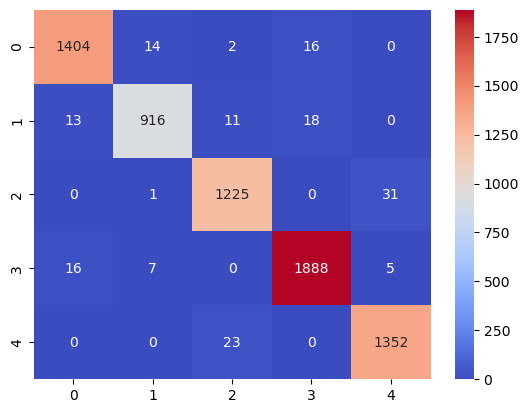

In [4]:
# Makes sure we don't get data leakage (splits folds based on session not rows)
gkfolds = GroupKFold(5)

# Gradient Boosted Classifier
# gb_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('selector', SelectKBest(mutual_info_classif)),
#     ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
# ])
    
# gb_grid = {
#     "selector__k": [20,30,40,"all"],
#     "classifier__n_estimators": [100, 200],
#     "classifier__learning_rate": [0.01, 0.05, 0.1],
#     "classifier__max_depth": [2, 3]
# }

# gb_search = GridSearchCV(gb_pipe, gb_grid, scoring="f1_macro", cv=gkfolds, n_jobs=-1)
# gb_search.fit(x, y_encoded, groups=groups)
# print("Gradient Boosting:")
# print(f"Best F1 Score: {gb_search.best_score_}")
# print(f"Best Params: {gb_search.best_params_}")

# SVC Classifier 
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_classif, k="all")),
    ('classifier', SVC(probability=True))
])

svc_grid = {
    "selector__k": [30, "all"],
    "classifier__C": [5, 10, 25, 35],
    "classifier__gamma": ["scale", "auto"],
    "classifier__kernel": ["rbf"],
    "classifier__degree": [2, 3]
}

svc_search = GridSearchCV(svc_pipe, svc_grid, scoring="f1_macro", cv=gkfolds, n_jobs=-1)
svc_search.fit(x, y_encoded, groups=groups)
print("SVC:")
print(f"Best F1: {svc_search.best_score_}")
print(f"Best Params: {svc_search.best_params_}")

# XGBoost Classifier
# xgboost_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('selector', SelectKBest(mutual_info_classif)),
#     ('classifier', XGBClassifier(
#         n_estimators=300,
#         n_jobs=1,
#         eval_metric="mlogloss",
#         tree_method="hist",
#         random_state=RANDOM_STATE
#     ))
# ])

# xgboost_grid = {
#     "selector__k": [20,"all"],
#     "classifier__n_estimators": [200, 300],
#     "classifier__max_depth": [3, 5],
#     "classifier__learning_rate": [0.05, 0.1],
#     "classifier__subsample": [0.7, 0.8],
#     "classifier__colsample_bytree": [0.7, 0.8]
# }

# xgboost_search = GridSearchCV(xgboost_pipe, xgboost_grid, scoring="f1_macro", cv=gkfolds, n_jobs=1, verbose=True)
# xgboost_search.fit(x, y_encoded, groups=groups)
# print("XGBoost...")
# print(f"Best F1: {xgboost_search.best_score_}")
# print(f"Best Params: {xgboost_search.best_params_}")

# best model -> xgboost 
best_model = svc_search.best_estimator_

# confusion matrix/metric report
y_predictedCV = cross_val_predict(svc_pipe, x, y_encoded, cv=gkfolds, groups=groups, n_jobs=-1)
print(classification_report(y_encoded, y_predictedCV))
cmatrix = confusion_matrix(y_encoded, y_predictedCV)
sns.heatmap(cmatrix, annot=True, cmap='coolwarm', fmt='d')
plt.show()


# print selected features:
# select_k_best = svc_search.best_estimator_.named_steps['selector']
# selected_indices = select_k_best.get_support(indices=True)
# Map the indices back to the feature names (from x)
# selected_features = x.columns[selected_indices]
# print("Selected Features:", selected_features)

# heat map of top 10 selected features
# top10_selected_feats = selected_features[:10]
# corr_top10 = x[top10_selected_feats].corr()
# plt.figure(figsize=(10,8))
# sns.heatmap(corr_top10, annot=True, cmap='coolwarm')
# plt.show()

In [5]:
dump(best_model, "speech_rec_model.pkl")

['speech_rec_model.pkl']